# Forces

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, './../auxnumerics/')
sys.path.insert(0, '../')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo_colloids as mc
import vertices as vrt

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [3]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

# Counts of flips up to some point
Here I counted how my flips have happened up to some time.

In [18]:
DRIVE = '/home/frieren/BIG/'
PROJECT = 'reentrancy/test11'
SIZE = 10
DATA_PATH = os.path.join(DRIVE,PROJECT,str(SIZE))

In [104]:
ifile = 'dishor_20mT.csv'
ofile = 'countshor_20mT.csv'

hors = pd.read_csv(os.path.join(DATA_PATH,ifile),header=0)
particle_cols = hors.columns[:-5].to_list()

# here we go by omega values
makeheaders = True
for ttime, dft in hors.groupby('total_time'):
    
    # here we normalize with respect to the trap separation
    normalized = dft[particle_cols] / params['trap_sep'].magnitude
    # and sum the particles that crossed the stuff with time
    # we consider crossed as 0.9 of the trap sep
    counts = pd.DataFrame((normalized>=0.9).sum(axis=1),columns=['counts'])
    counts['total_time'] = [ttime] * len(counts)
    counts['t'] = dft.t
    
    if makeheaders:
        counts.to_csv(os.path.join(DATA_PATH,ofile),mode='w',index=False)
        makeheaders=False
    else:
        counts.to_csv(os.path.join(DATA_PATH,ofile),mode='a',index=False, header=None)

In [66]:
countsh = pd.read_csv(os.path.join(DATA_PATH,'countshor_20mT.csv'),index_col=['total_time','t'])
countsv = pd.read_csv(os.path.join(DATA_PATH,'countsver_20mT.csv'),index_col=['total_time','t'])
n_particles = 2 * params['size']**2

fractions = pd.DataFrame( pd.concat([countsh,countsv],axis=1).sum(axis=1) / n_particles , columns=['fractions']) 
fractions['omega'] = np.round(np.pi/2/fractions.index.get_level_values('total_time').to_numpy(),4)

ws = fractions.omega.unique()
ws = ws[(ws<=0.2) & (ws>=0.01)]
ws

array([0.1963, 0.1745, 0.1571, 0.1428, 0.1309, 0.1208, 0.1122, 0.1047,
       0.0982, 0.0924, 0.0873, 0.0827, 0.0785, 0.0524, 0.0393, 0.0314,
       0.0224, 0.0196, 0.0175, 0.0157])

In [67]:
fractions

fractions   omega
total_time t                        
1.0        0.00        0.000  1.5708
           0.05        0.000  1.5708
           0.10        0.000  1.5708
           0.15        0.000  1.5708
           0.20        0.000  1.5708
...                      ...     ...
1000.0     999.75      0.400  0.0016
           999.80      0.400  0.0016
           999.85      0.400  0.0016
           999.90      0.395  0.0016
           999.95      0.400  0.0016

[334000 rows x 2 columns]

In [69]:
averaged = pd.DataFrame(fractions.groupby(['omega','t'])['fractions'].mean()).reset_index()

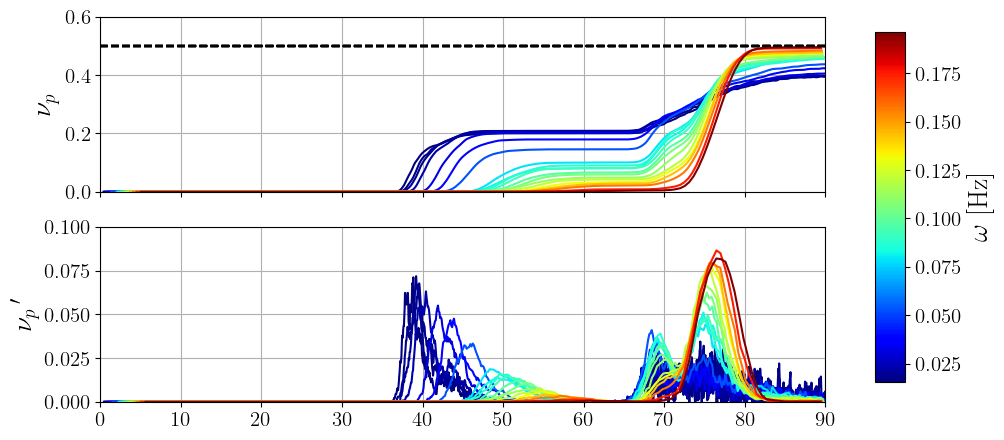

In [116]:
fig, axes = plt.subplots(2,1,figsize=(10,5))

norm = plt.Normalize(min(ws),max(ws))
cmap = plt.get_cmap('jet')

ylabels = [
    '$\\nu_p$',
    '$\\nu_p \\, \'$'
]


for w, dfw in averaged.groupby('omega'):
    if w in ws:
        N = 10 
        window = np.ones(N)/N
        
        theta = (dfw.omega * dfw.t) * 180/np.pi
        
        res = np.convolve(dfw.fractions,window,mode='valid')
        th = theta[N-1:]
        
        axes[0].plot(th, res, color=cmap(norm(w)))
        axes[0].axhline(y=0.5,linestyle='--', color='k')
        
        axes[1].plot(th[1:],(np.diff(res) / np.diff(th)) , color=cmap(norm(w)))

        
for i in range(2):
    axes[i].grid()
    axes[i].set_xlim(0,90)
    axes[i].set_ylabel(ylabels[i])
    
    if i==0:
        axes[i].set_ylim(0,0.6)
        axes[i].set_xticklabels([])
    else:
        axes[i].set_ylim(0,0.1)


fig.subplots_adjust(right=0.85)  # Adjust the right space to make room for the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])  # [left, bottom, width, height] for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(label='$\\omega$ [Hz]',fontsize=20)
cbar.ax.tick_params(labelsize=15) 

plt.show()

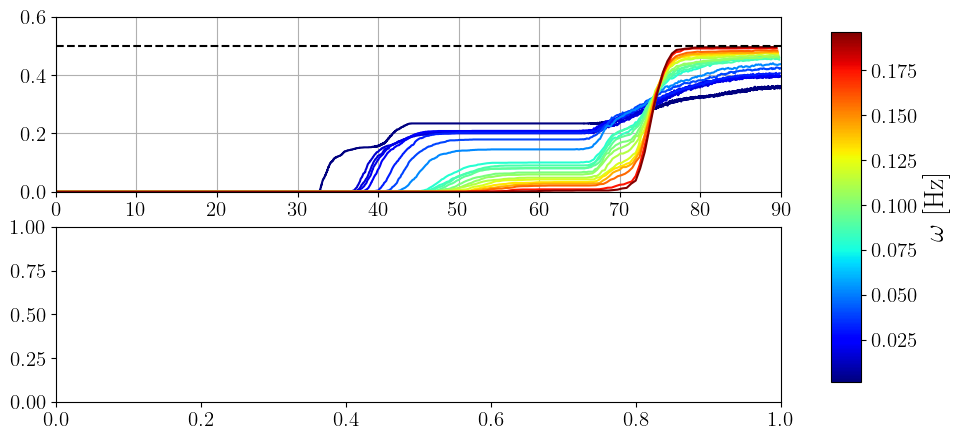

In [29]:
fig, axes = plt.subplots(2,1,figsize=(10,5))

norm = plt.Normalize(min(ws),max(ws))
cmap = plt.get_cmap('jet')


for w, dfw in fractions.reset_index().groupby('omega'):
    if w in ws:
        theta = (dfw.omega * dfw.t).unique() * 180/np.pi
        # this is to get the average across realizations
        result = dfw.groupby('t')['fractions'].mean()
        axes[0].plot(theta, result, color=cmap(norm(w)))
        axes[0].set_xlim(0,90)
        axes[0].set_ylim(0,0.6)

axes[0].grid()
axes[0].axhline(y=0.5,linestyle='--', color='k')

fig.subplots_adjust(right=0.85)  # Adjust the right space to make room for the colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])  # [left, bottom, width, height] for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(label='$\\omega$ [Hz]',fontsize=20)
cbar.ax.tick_params(labelsize=15) 

plt.show()

# Making some binnings
I was not exactly what I wanted, I wanted the amounts of flips that happen in a given timeframe.

In [12]:
# preparing some binnings
h = 5 
bins = np.arange(0,90,h)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85])

In [13]:
ifile = 'dishor_20mT.csv'
data = pd.read_csv(os.path.join(DATA_PATH,ifile)).theta

In [ ]:
th = 
data.query(f'theta>={}')